In [1]:
%matplotlib inline

from datetime import timedelta
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

DATA_RAW = Path(os.getcwd()) / os.pardir / "data" / "raw" / "optimization"
DATA_FINAL = Path(os.getcwd()) / os.pardir / "data" / "final" / "optimization"

# Process data

In [2]:
old_steps = list(range(15, 1455, 15))
new_steps = range(96)

old_columns = [f"PV_Forecast_{s}" for s in old_steps] + [f"Load_Forecast_{s}" for s in old_steps]
new_columns = [f"pv_{s:02d}" for s in new_steps] + [f"load_{s:02d}" for s in new_steps]

rename_map = dict(zip(old_columns, new_columns))

rename_map.update({
    'Timestamp': 'timestamp',
    'SiteId': 'site_id',
    'Load_Values': 'actual_consumption',
    'PV_Values': 'actual_pv'
})

In [93]:
def get_price_data(df, forecast_len=96):
    """ Reshape df up to row n-96 to have 
        to 96 col arrays with buy and sell prices.
    """
    arrays = []
    
#     df.index.name = 'original_index'
#     df.reset_index(inplace=True)
    
    for i in range(df.shape[0] - forecast_len):
        next_n_buy = df.Purchase_Price[i:i + forecast_len].copy()
        next_n_sell = df.Sale_Price[i:i + forecast_len].copy()
        
        next_buy_sell = np.hstack((next_n_buy, next_n_sell))
        
        arrays.append(next_buy_sell)
        
    cols = [f"price_buy_{s:02d}" for s in range(forecast_len)] + \
           [f"price_sell_{s:02d}" for s in range(forecast_len)]
    
    price_df =  pd.DataFrame(data=arrays,
                             columns=cols,
                             index=df.index[:-forecast_len])
    
    return price_df


def process_raw(f, out_path=None):
    # load data
    df = pd.read_csv(f, parse_dates=['Timestamp'], sep=';')
    
    # create period ids if we go from secret to given1 or if timedelta > 15m
    df['period_id'] = ((df.Timestamp.diff() != timedelta(minutes=15)) | 
                       ((df.given == 'given1') & (df.given.shift(1) == 'secret'))).cumsum()
    
    # rename columns
    df.rename(columns=rename_map, inplace=True)
    
    period_dfs = []
    for pid in df.period_id.unique():
        this_period = df[df.period_id == pid].copy()
        price_data = get_price_data(this_period)
        
        period_dfs.append(pd.concat([this_period.iloc[:-96, :], price_data], axis=1))
        
    df = pd.concat(period_dfs, axis=0)
    
    train = df[df.given == 'given1'].copy()
    test = df[df.given == 'given2'].copy()
    private = df[df.given == 'secret'].copy()

    # write to disk per group
    for folder, sub_df in [('train', train), ('submit', test), ('eval', private)]:
    
        # drop "given"
        sub_df.drop('given', axis=1, inplace=True)

        prefixes = ['load', 'pv', 'price_buy', 'price_sell']
        ordered_columns = [f"{pre}_{d:02d}" for pre in prefixes for d in range(96) ]

        # order columns sensibly
        sub_df = sub_df[['timestamp', 'site_id', 'period_id', 'actual_consumption', 'actual_pv'] + ordered_columns]
        sub_df.set_index('timestamp', inplace=True)
        
        sub_df.to_csv(out_path/folder/f.name)
    

# f = DATA_RAW/'Secret'/'2.csv' 
# dd = process_raw(f, DATA_FINAL)
    
for f in (DATA_RAW/'Secret').glob('[0-9]*.csv'):
    process_raw(f, DATA_FINAL)

In [3]:
test_df = pd.read_csv(DATA_FINAL/'eval'/'2.csv', parse_dates=['timestamp'], index_col=['timestamp'])

test_df.reset_index().groupby('period_id').timestamp.apply(lambda x: (x.diff() > timedelta(minutes=15)).any())

period_id
1    False
2    False
3    False
4    False
5    False
6    False
Name: timestamp, dtype: bool

In [4]:
f = DATA_RAW/'Secret'/'2.csv' 
df = pd.read_csv(f, parse_dates=['Timestamp'], sep=';')

In [5]:
raw_eval_2 = df[df.given == 'secret']
raw_eval_2.head()

,Timestamp,Load_Forecast_1005,Load_Forecast_1020,Load_Forecast_1035,Load_Forecast_105,Load_Forecast_1050,Load_Forecast_1065,Load_Forecast_1080,Load_Forecast_1095,Load_Forecast_1110,...,PV_Forecast_945,PV_Forecast_960,PV_Forecast_975,PV_Forecast_990,PV_Values,SiteId,Load_Values,Purchase_Price,Sale_Price,given
4800,2014-12-27 16:45:00,11627.278145,11627.278145,11627.278145,10474.814157,11627.278145,11627.278145,11627.278145,11627.024884,11627.024884,...,16939.722318,25505.972661,23108.144118,22380.741301,0.0,2,9099.625374,0.083,0.031,secret
4801,2014-12-27 17:00:00,11627.278145,11627.278145,11627.278145,9830.443583,11627.278145,11627.278145,11627.024884,11627.024884,11627.024884,...,25505.972661,23108.144118,22380.741301,27528.062759,0.0,2,9099.625374,0.153,0.031,secret
4802,2014-12-27 17:15:00,11627.278145,11627.278145,11627.278145,10028.842185,11627.278145,11627.024884,11627.024884,11627.024884,11627.024884,...,23108.144118,22380.741301,27528.062759,37489.938485,0.0,2,9099.625374,0.153,0.031,secret
4803,2014-12-27 17:30:00,11627.278145,11627.278145,11627.278145,9540.592218,11627.024884,11627.024884,11627.024884,11627.024884,9383.924381,...,22380.741301,27528.062759,37489.938485,36356.198079,0.0,2,9099.625374,0.153,0.031,secret
4804,2014-12-27 17:45:00,11627.278145,11627.278145,11627.024884,9742.163046,11627.024884,11627.024884,11627.024884,9383.924381,9373.969054,...,27528.062759,37489.938485,36356.198079,39174.798142,0.0,2,9099.625374,0.153,0.031,secret


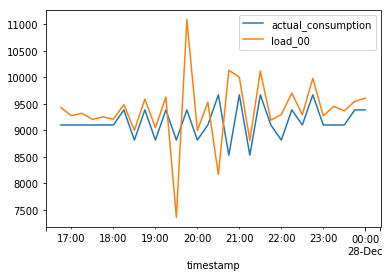

In [21]:
test_df[['actual_consumption', 'load_00']].head(30).plot()

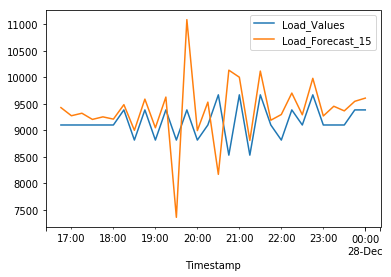

In [22]:
raw_eval_2.set_index('Timestamp')[['Load_Values', 'Load_Forecast_15']].head(30).plot()

# Metadata

In [2]:
metadata = pd.read_csv(DATA_RAW/'Metadata'/'site-meta.csv', sep=";", decimal=',', index_col=0)

metadata.to_csv(DATA_FINAL/'public'/'metadata.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bull/schneider/data-preparation/../data/final/optimization/public/metadata.csv'